In [1]:
import os

# Use the eager mode
os.environ['PT_HPU_LAZY_MODE'] = '0'

# Verify the environment variable is set
print(f"PT_HPU_LAZY_MODE: {os.environ['PT_HPU_LAZY_MODE']}")

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import habana_frameworks.torch.core as htcore

PT_HPU_LAZY_MODE: 0


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)


2.4.0a0+git74cd574


/usr/lib/python3.10/inspect.py:288: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(object, types.FunctionType)


In [2]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

# Node2Vec for link prediction

In this tutorial, we use the node embedding produced by Node2Vec, then we compute the edge embedding $(emb(E))$ as follow:

$$
emb(E) = emb(u,v) = \frac{1}{2}(Emb(u) + Emb(v))
$$

given the edge embedding we predict the binary label of the node using RandomForestClassifier


## step 1
Build a dataset different from cora :)  
  
We use AIDS[1][2] a dataset representing 2000 moleculas compounds, each moleculas is represented as a graph and each graph has an attribute indicating if the compound is active or inactive against HIV. 


<sub>[1] Riesen, K. and Bunke, H.: IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning. In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.  
[2] AIDS Antiviral Screen Data (2004)

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
device = torch.device("hpu")
dataset = "AIDS"
data = TUDataset(".", name=dataset)

Processing...
Done!


### The dataset

In [4]:
print(data)
print("number of classes: ",data.num_classes,"\t\t(active),(inactive)")
print("number of features: ",data.num_features)
print("number of edge labels: ",data.num_edge_labels)

AIDS(2000)
number of classes:  2 		(active),(inactive)
number of features:  38
number of edge labels:  3


In [5]:
data1 = data[1]

# extract edge list
edge_list = data1.edge_index.t().numpy()
print(edge_list[0:10])

[[0 1]
 [0 5]
 [1 0]
 [1 2]
 [1 6]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [3 7]]


In [6]:
# extract edge attributes
edge_attr = data1.edge_attr.numpy()
print(edge_attr[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [7]:
import networkx as nx

# build the graph
graph1 = nx.Graph()

for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph1.add_edge(u,v,label=edge_attr[i])
    
print(graph1.edges(data=True))

[(0, 1, {'label': array([1., 0., 0.], dtype=float32)}), (0, 5, {'label': array([1., 0., 0.], dtype=float32)}), (1, 2, {'label': array([1., 0., 0.], dtype=float32)}), (1, 6, {'label': array([0., 1., 0.], dtype=float32)}), (5, 4, {'label': array([1., 0., 0.], dtype=float32)}), (5, 8, {'label': array([1., 0., 0.], dtype=float32)}), (2, 3, {'label': array([1., 0., 0.], dtype=float32)}), (3, 4, {'label': array([1., 0., 0.], dtype=float32)}), (3, 7, {'label': array([0., 1., 0.], dtype=float32)}), (4, 9, {'label': array([1., 0., 0.], dtype=float32)}), (4, 10, {'label': array([1., 0., 0.], dtype=float32)})]


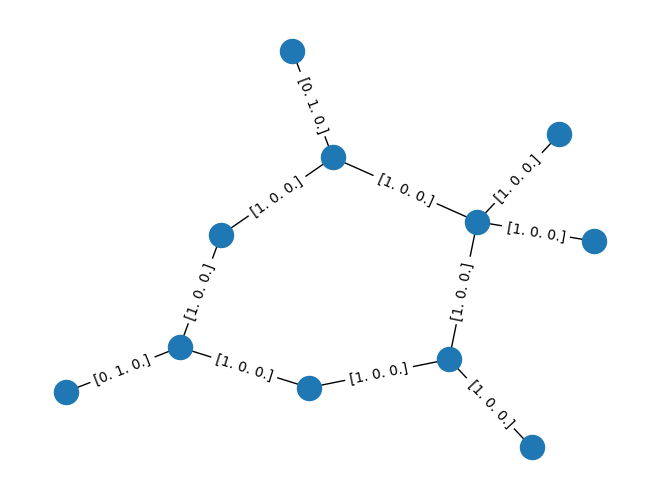

In [8]:
pos = nx.spring_layout(graph1)
nx.draw(graph1,pos)
nx.draw_networkx_edge_labels(graph1,pos,nx.get_edge_attributes(graph1,'label'))
plt.show()

### Use only one moleculas compound

In [9]:
data.data

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[31385, 38], edge_index=[2, 64780], edge_attr=[64780, 3], y=[2000])

In [10]:
data = data[10]
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

### build the graph with
train_mask, test_mask, val_mask

In [11]:
np.random.seed(10)
# get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

np.random.shuffle(nodes) # shuffle node order
print(len(nodes))

76


In [12]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [13]:
# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(nodes))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

53 11 12
True
train set	 [68 26 21  3 44 41  6 20  2 60]
test set 	 [13 73 51 49 14 67 70 33 58 43]
val set  	 [54 11 16 36 40  0  8 29 28 64]


In [14]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0], device='hpu:0')
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='hpu:0')
val mask   	 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0], device='hpu:0')


============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 0
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2113407800 KB
------------------------------------------------------------------------------


In [15]:
# remove from the data what do we not use.

print("befor\t\t",data)
data.x = None
data.edge_attr = None
data.y = None

befor		 Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])


In [16]:
# add masks
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

print("after\t\t",data)

after		 Data(edge_index=[2, 166], train_mask=[76], test_mask=[76], val_mask=[76])


## step 2
Execute Node2Vec to get node embeddings

In [17]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device("hpu")

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


ImportError: 'Node2Vec' requires either the 'pyg-lib' or 'torch-cluster' package

In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
        

In [ ]:
z = model()

### visualize node embedding

In [ ]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

In [ ]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

## Step 3
Compute edge embedding

In [ ]:
# reload AIDS dataset 
# and pick the same graph


dataset = "AIDS"
data = TUDataset(".", name=dataset)
data = data[10]

In [ ]:
# convert edge attributes from categorical to numerical
edge_attr_cat = data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

In [ ]:
# compute edge embedding

edge_embedding = []
for u,v in data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))

### visualize edge embedding


In [ ]:
import pandas as pd
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors))
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2

# Step 4
Use RandomForestClassifier with 10-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=7,random_state=10)


scores = cross_val_score(clf, edge_embedding, edge_attr, cv=10)
np.mean(scores)